In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gdown

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
trader_data_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
sentiment_data_id = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

trader_data_file = 'Mustufa_Shaikh/needed/csv_files/hyperliquid_trader_data.csv'
sentiment_data_file = 'fear_and_greed_index.csv'

# Download files from Google Drive
print("Downloading datasets...")
gdown.download(id=trader_data_id, output=trader_data_file, quiet=False)
gdown.download(id=sentiment_data_id, output=sentiment_data_file, quiet=False)
print("Downloads complete.")

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/hyperliquid_trader_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 61.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_and_greed_index.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 37.9MB/s]

Downloads complete.


In [6]:
# Load datasets into pandas
try:
    df_trader = pd.read_csv('/Mustufa_Shaikh/needed/csv_files/hyperliquid_trader_data.csv')
    df_sentiment = pd.read_csv('/Mustufa_Shaikh/needed/csv_files/fear_and_greed_index.csv')
    print("Files loaded into DataFrames.")
    print("\nTrader Data Head:")
    print(df_trader.head())
    print("\nSentiment Data Head:")
    print(df_sentiment.head())
except Exception as e:
    print(f"Error loading CSVs: {e}")

Files loaded into DataFrames.

Trader Data Head:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transac

In [11]:
trader_rename_map = {
    'Timestamp': 'time',  # This is the Unix ms timestamp (e.g., 1.730000e+12)
    'Execution Price': 'execution price',
    'Size USD': 'size',
    'Closed PnL': 'closedPnL',
    'Direction': 'side'   # 'Direction' (Buy/Sell) maps to 'side'
}

print(f"Original trader columns: {df_trader.columns.to_list()}")
df_trader = df_trader.rename(columns=trader_rename_map)
print(f"Renamed trader columns: {df_trader.columns.to_list()}")


# Convert 'time' to datetime objects.
try:
    # The 'time' column (originally 'Timestamp') is likely Unix ms
    df_trader['time'] = pd.to_datetime(df_trader['time'], unit='ms')
except Exception as e:
    print(f"Could not convert 'time' (from Timestamp) as ms, trying as string: {e}")
    # Fallback if it's already a string or a different format
    df_trader['time'] = pd.to_datetime(df_trader['time'])

# Create a 'date' column (YYYY-MM-DD) for merging
df_trader['date'] = df_trader['time'].dt.date
df_trader['date'] = pd.to_datetime(df_trader['date'])

# Define numeric columns *that exist*
# 'leverage' is NOT in the observed data, so it's removed.
numeric_cols = ['execution price', 'size', 'closedPnL']
for col in numeric_cols:
    if col in df_trader.columns:
        df_trader[col] = pd.to_numeric(df_trader[col], errors='coerce')
    else:
        print(f"Warning: Numeric column '{col}' not found after rename.")

# Drop rows where key numeric values are missing
# 'leverage' is removed from this list
df_trader = df_trader.dropna(subset=['size', 'closedPnL'])

# --- Clean Sentiment Data ---
# Rename columns for easier access, based on image ('classification' and 'date')
sentiment_rename_map = {
    'classification': 'sentiment',
    'date': 'date' # This is often already correct
}
# Also handle the original script's expected names, just in case
if 'Classification' in df_sentiment.columns:
    sentiment_rename_map['Classification'] = 'sentiment'
if 'Date' in df_sentiment.columns:
    sentiment_rename_map['Date'] = 'date'

print(f"Original sentiment columns: {df_sentiment.columns.to_list()}")
df_sentiment = df_sentiment.rename(columns=sentiment_rename_map)
print(f"Renamed sentiment columns: {df_sentiment.columns.to_list()}")


# Convert 'date' to datetime objects
if 'date' in df_sentiment.columns:
    df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
else:
    print("Error: 'date' column not found in sentiment data after rename attempts.")

print("\nCleaning complete.")
print("Trader data info:")
df_trader.info()
print("\nSentiment data info:")
df_sentiment.info()

Original trader columns: ['Account', 'Coin', 'execution price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'side', 'closedPnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'time', 'date']
Renamed trader columns: ['Account', 'Coin', 'execution price', 'Size Tokens', 'size', 'Side', 'Timestamp IST', 'Start Position', 'side', 'closedPnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'time', 'date']
Original sentiment columns: ['timestamp', 'value', 'classification', 'date']
Renamed sentiment columns: ['timestamp', 'value', 'sentiment', 'date']

Cleaning complete.
Trader data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           211224 non-null  object        
 1   Coin              211224 non-null  object        
 2   execution price  

In [13]:
print("\nAggregating trader data by day...")

# 1. Daily Total PnL
daily_pnl = df_trader.groupby('date')['closedPnL'].sum().reset_index(name='total_pnl')

# 2. Daily Total Volume (using 'size')
daily_volume = df_trader.groupby('date')['size'].sum().reset_index(name='total_volume')

# 3. Daily Average Leverage - REMOVED as 'leverage' column is not available
# daily_leverage = df_trader.groupby('date')['leverage'].mean().reset_index(name='avg_leverage')
print("Skipping daily leverage calculation (column not found).")

# 4. Daily Trade Count
daily_trades = df_trader.groupby('date').size().reset_index(name='trade_count')

# 5. Daily Long/Short Volume
daily_side_volume = pd.DataFrame(columns=['date', 'long_volume', 'short_volume']) # Init empty
if 'execution price' in df_trader.columns and 'side' in df_trader.columns:
    # Calculate trade value
    df_trader['volume'] = df_trader['execution price'] * df_trader['size']

    # Normalize 'side' column (e.g., 'Buy' -> 'buy', 'Sell' -> 'sell')
    df_trader['side'] = df_trader['side'].str.lower()

    daily_side_volume = df_trader.groupby(['date', 'side'])['volume'].sum().unstack(fill_value=0)

    # Ensure both 'buy' and 'sell' columns exist after unstacking
    if 'buy' not in daily_side_volume.columns:
        daily_side_volume['buy'] = 0
    if 'sell' not in daily_side_volume.columns:
        daily_side_volume['sell'] = 0

    daily_side_volume = daily_side_volume.rename(columns={'buy': 'long_volume', 'sell': 'short_volume'})
    daily_side_volume = daily_side_volume.reset_index()
else:
    print("Warning: 'execution price' or 'side' (from 'Direction') column not found. Skipping long/short analysis.")


# Merge all aggregated dataframes
print("Merging daily aggregates...")
# 'daily_leverage' is removed from the list
dfs_to_merge = [daily_pnl, daily_volume, daily_trades, daily_side_volume]

df_daily_agg = dfs_to_merge[0]
for df in dfs_to_merge[1:]:
    if not df.empty: # Only merge if the dataframe was created
        df_daily_agg = pd.merge(df_daily_agg, df, on='date', how='outer')

# --- Merge with Sentiment Data ---
df_analysis = pd.DataFrame() # Init empty
if 'date' in df_daily_agg and 'date' in df_sentiment:
    df_analysis = pd.merge(df_daily_agg, df_sentiment, on='date', how='inner')
else:
    print("Error: Cannot merge aggregated and sentiment data. 'date' column missing from one or both.")

# --- Final Features ---
# Calculate Long/Short Ratio (handle division by zero)
if 'long_volume' in df_analysis.columns and 'short_volume' in df_analysis.columns:
    df_analysis['long_short_ratio'] = df_analysis['long_volume'] / (df_analysis['short_volume'] + 1e-6)
else:
    df_analysis['long_short_ratio'] = np.nan

# Save the processed data to the csv_files directory
processed_data_path = '/Mustufa_Shaikh/needed/csv_files/daily_behavior_sentiment_analysis.csv'
df_analysis.to_csv(processed_data_path, index=False)
print(f"Processed analysis data saved to {processed_data_path}")
print("\nFinal Analysis DataFrame Head:")
print(df_analysis.head())


Aggregating trader data by day...
Skipping daily leverage calculation (column not found).
Merging daily aggregates...
Processed analysis data saved to /content/needed/csv_files/daily_behavior_sentiment_analysis.csv

Final Analysis DataFrame Head:
        date     total_pnl  total_volume  trade_count  auto-deleveraging  \
0 2023-03-28  0.000000e+00  4.770000e+02            3           0.000000   
1 2023-11-14  1.555034e+02  1.155543e+07         1045           0.000000   
2 2024-03-09  1.769655e+05  3.940677e+07         6962           0.000000   
3 2024-07-03  1.587424e+05  2.184323e+07         7141      583666.485871   
4 2024-10-27  3.189461e+06  1.039478e+08        35241           0.000000   

    long_volume    close long   close short  liquidated isolated short  \
0  0.000000e+00  0.000000e+00  0.000000e+00                        0.0   
1  0.000000e+00  6.844534e+10  3.908008e+10                        0.0   
2  1.329539e+04  7.962772e+10  1.885405e+11                        0.0   


Generating visualizations...
Saved outputs/sentiment_distribution.png
Saved outputs/pnl_vs_sentiment.png
Saved outputs/volume_vs_sentiment.png
Skipping Leverage vs. Sentiment plot (leverage data not available).
Saved outputs/long_short_vs_sentiment.png

All available visualizations generated and saved to /content/outputs/


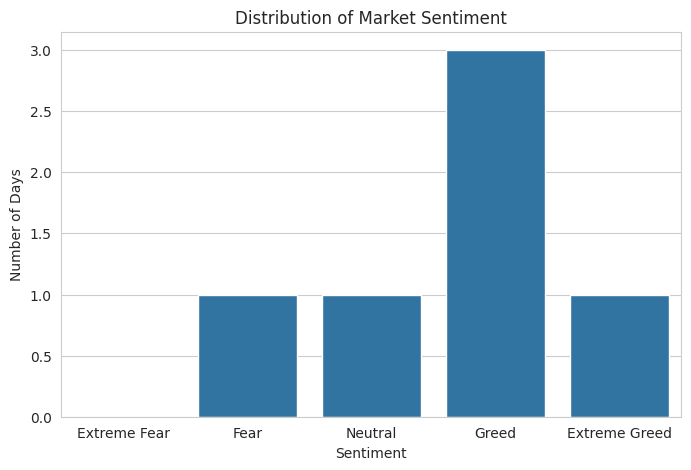

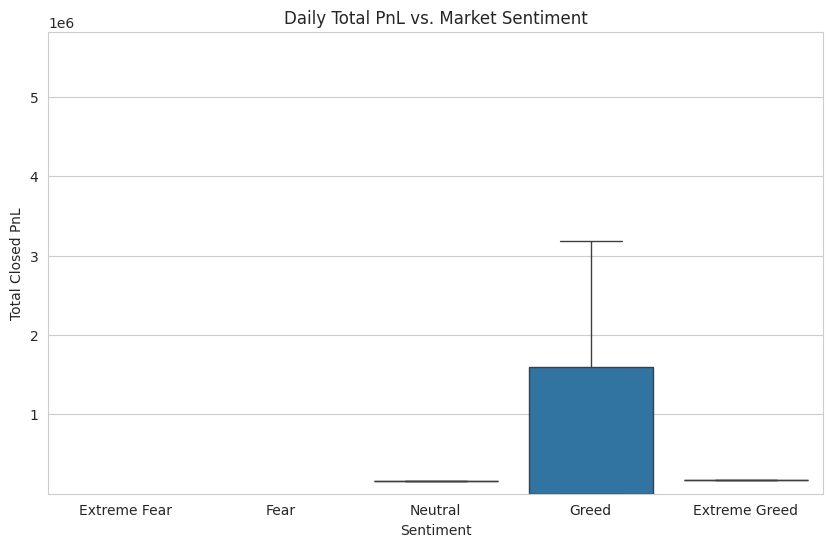

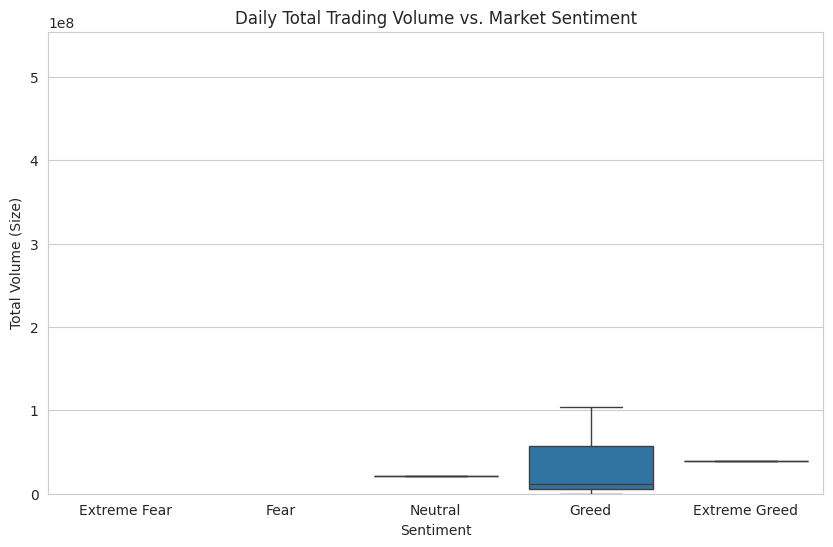

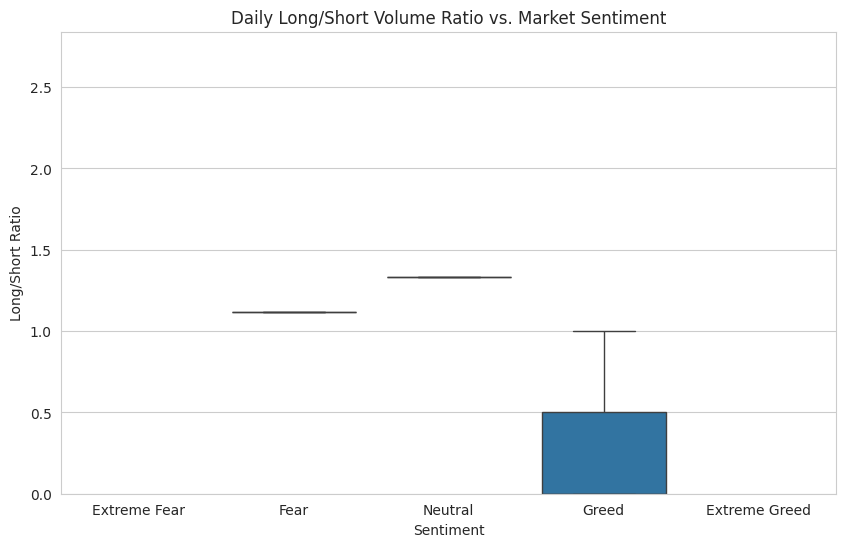

In [20]:
print("\nGenerating visualizations...")

if df_analysis.empty or 'sentiment' not in df_analysis.columns:
    print("Analysis dataframe is empty or 'sentiment' column is missing. Skipping visualizations.")
else:
    # Define sentiment order for plots
    sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

    # Filter df_analysis to only include rows with sentiment values in our defined order
    df_analysis_filtered = df_analysis[df_analysis['sentiment'].isin(sentiment_order)].copy()

    if df_analysis_filtered.empty:
        print(f"No data found for sentiment categories: {sentiment_order}. Skipping plots.")
    else:
        # Plot 1: Sentiment Distribution
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df_analysis_filtered, x='sentiment', order=sentiment_order)
        plt.title('Distribution of Market Sentiment')
        plt.ylabel('Number of Days')
        plt.xlabel('Sentiment')
        plt.savefig('/Mustufa_Shaikh/needed/outputs/sentiment_distribution.png')
        print("Saved outputs/sentiment_distribution.png")

        # Plot 2: Daily Total PnL vs. Sentiment
        if 'total_pnl' in df_analysis_filtered.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=df_analysis_filtered, x='sentiment', y='total_pnl', order=sentiment_order)
            plt.title('Daily Total PnL vs. Market Sentiment')
            plt.ylabel('Total Closed PnL')
            plt.xlabel('Sentiment')
            # Remove outliers for better viz
            pnl_q05 = df_analysis_filtered['total_pnl'].quantile(0.05)
            pnl_q95 = df_analysis_filtered['total_pnl'].quantile(0.95)
            if not np.isnan(pnl_q05) and not np.isnan(pnl_q95) and pnl_q05 < pnl_q95:
                plt.ylim(pnl_q05, pnl_q95)
            plt.savefig('/Mustufa_Shaikh/needed/outputs/pnl_vs_sentiment.png')
            print("Saved outputs/pnl_vs_sentiment.png")
        else:
            print("Skipping PnL vs. Sentiment plot (column 'total_pnl' not found).")


        # Plot 3: Daily Trading Volume vs. Sentiment
        if 'total_volume' in df_analysis_filtered.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=df_analysis_filtered, x='sentiment', y='total_volume', order=sentiment_order)
            plt.title('Daily Total Trading Volume vs. Market Sentiment')
            plt.ylabel('Total Volume (Size)')
            plt.xlabel('Sentiment')
            # Remove outliers
            vol_q95 = df_analysis_filtered['total_volume'].quantile(0.95)
            if not np.isnan(vol_q95):
                plt.ylim(0, vol_q95)
            plt.savefig('/Mustufa_Shaikh/needed/outputs/volume_vs_sentiment.png')
            print("Saved outputs/volume_vs_sentiment.png")
        else:
            print("Skipping Volume vs. Sentiment plot (column 'total_volume' not found).")

        # Plot 4: Average Leverage vs. Sentiment - REMOVED
        print("Skipping Leverage vs. Sentiment plot (leverage data not available).")

        # Plot 5: Long/Short Ratio vs. Sentiment
        if 'long_short_ratio' in df_analysis_filtered.columns and df_analysis_filtered['long_short_ratio'].notna().any():
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=df_analysis_filtered, x='sentiment', y='long_short_ratio', order=sentiment_order)
            plt.title('Daily Long/Short Volume Ratio vs. Market Sentiment')
            plt.ylabel('Long/Short Ratio')
            plt.xlabel('Sentiment')
            # Remove outliers
            ls_q95 = df_analysis_filtered['long_short_ratio'].quantile(0.95)
            if not np.isnan(ls_q95):
                plt.ylim(0, ls_q95)
            plt.savefig('/Mustufa_Shaikh/needed/outputs/long_short_vs_sentiment.png')
            print("Saved outputs/long_short_vs_sentiment.png")
        else:
            print("Skipping Long/Short Ratio vs. Sentiment plot (column 'long_short_ratio' not found or all NaN).")

    print("\nAll available visualizations generated and saved to /content/outputs/")


In [26]:
df_analysis_filtered['sentiment'].mode()


,sentiment
0,Greed
